# Отправка запроса в Тритон

In [1]:
!python /app/src/client.py --image /app/dataset/test_imgs/horses.jpg --num-reqs 100

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.90it/s]
Среднее время обработки запроса: 0.09160543918609619 s


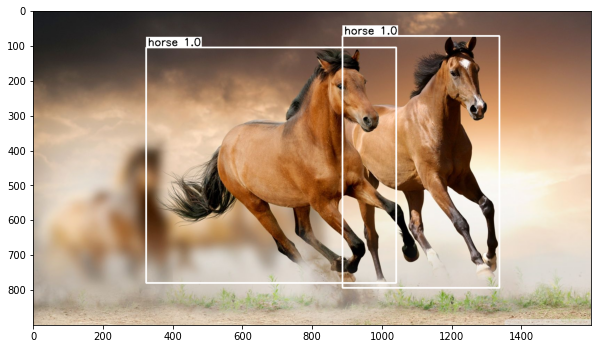

In [2]:
import tritonclient.http as httpclient
from PIL import Image
import numpy as np
import cv2
import bbox_visualizer as bbv
import matplotlib.pyplot as plt


CLASSES = [
    'person', 'bicycle', 'car',
    'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat',
    'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird',
    'cat', 'dog', 'horse', 'sheep',
    'cow', 'elephant', 'bear', 'zebra', 'giraffe',
    'backpack', 'umbrella', 'handbag', 'tie', 'suitcase',
    'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
    'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv',
    'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


def infer(image_file, model_name='faster_rcnn'):
    img = np.array(Image.open(image_file))
    img = np.ascontiguousarray(img.transpose(2, 0, 1))
    inputs = []
    inputs.append(httpclient.InferInput('image__0', img.shape, "UINT8"))
    inputs[0].set_data_from_numpy(img)
    outputs = []
    outputs.append(httpclient.InferRequestedOutput('bboxes__0'))
    outputs.append(httpclient.InferRequestedOutput('classes__1'))
    outputs.append(httpclient.InferRequestedOutput('scores__2'))
    outputs.append(httpclient.InferRequestedOutput('shape__3'))
    triton_client = httpclient.InferenceServerClient(
        url="triton:8000", verbose=False)
    results = triton_client.infer(model_name, inputs=inputs, outputs=outputs)
    response_info = results.get_response()
    outputs = {}
    for output_info in response_info['outputs']:
        output_name = output_info['name']
        outputs[output_name] = results.as_numpy(output_name)
    return outputs


def draw_outputs_on_image(image_path, outputs, threshold):
    threshold_outputs = {'bboxes':[], 'classes': [], 'scores':[]}
    for bbox, category, score in zip(outputs['bboxes__0'], outputs['classes__1'], outputs['scores__2']):
        if score > 0.8:
            threshold_outputs['bboxes'].append(bbox)
            threshold_outputs['classes'].append(category)
            threshold_outputs['scores'].append(score)

    # Reading an image in default mode
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bboxes = [list(map(int, i)) for i in threshold_outputs['bboxes']]
    image_1 = bbv.draw_multiple_rectangles(image, bboxes)

    classes = [f"{CLASSES[number_of_class]} {round(score, 1)}" for number_of_class, score in zip(threshold_outputs['classes'], threshold_outputs['scores'])]
    image_2 = bbv.add_multiple_labels(image_1, classes, bboxes)
    plt.figure(figsize=(10,10)); plt.imshow(image_2) 
    
    
image_file = '/app/dataset/test_imgs/horses.jpg'
result = infer(image_file)
draw_outputs_on_image(image_file, result, 0.9)